In [1]:
!pip install torch
!pip install optuna

In [2]:
!pip install librosa

In [3]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import torch 
from torch.utils.data import Dataset, DataLoader, random_split, Subset

In [4]:

df=pd.read_csv("/Users/jeevansai/Desktop/PYTHON FOR DATA SCIENCE/AIML Vth semester/project on neural networks/FSD50K_Data.csv")
print(df.head(10))
audio_dir = "audios"
output_path = "processed_data.npz"
print(df['label'].unique())

print(df['location'].unique())

print(df['risk_level'].unique())



SAMPLE_RATE = 22050
N_MELS = 128
SPEC_SHAPE = (128, 128)
duration = 5

df = pd.read_csv("FSD50K_Data.csv")

risk_encoder = LabelEncoder()
df['risklevel_encoded'] = risk_encoder.fit_transform(df['risk_level'])

location_encoder = LabelEncoder()
df['location_encoded'] = location_encoder.fit_transform(df['location'])


X = []
locations = []
y = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    file_path = os.path.join(audio_dir, f"{row['fname']}.wav")
    if not os.path.isfile(file_path):
        continue

    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE,duration=duration)

    if len(audio) < sr * duration:
        audio = np.pad(audio, (0,sr*duration - len(audio)))
        
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MELS)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    mel_db = librosa.util.fix_length(mel_db, size=216, axis=1)

    mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-9) # Normalize

    X.append(mel_db)
    y.append(row['risklevel_encoded'])
    locations.append(row["location_encoded"])


X = np.array(X).astype(np.float32)
y = np.array(y)
locations = np.array(locations)

# Save
np.savez(output_path, X=X, y=y, locations=locations, risklevel_classes = risk_encoder.classes_, location_classes = location_encoder.classes_)

print(f"Saved preprocessed data to {output_path}")


    fname            label location risk_level
0  128802  Acoustic_guitar     Home     Normal
1    8462  Acoustic_guitar     Home     Normal
2   41750  Acoustic_guitar     Home     Normal
3  252380  Acoustic_guitar     Home     Normal
4   18483  Acoustic_guitar     Home     Normal
5   68968  Acoustic_guitar     Home     Normal
6  183757  Acoustic_guitar     Home     Normal
7  183718  Acoustic_guitar     Home     Normal
8   58031  Acoustic_guitar     Home     Normal
9   58085  Acoustic_guitar     Home     Normal
['Acoustic_guitar' 'Alarm' 'Applause' 'Bark' 'Bass_guitar' 'Bird'
 'Bowed_string_instrument' 'Brass_instrument' 'Breathing' 'Camera'
 'Clapping' 'Coin_(dropping)' 'Domestic_sounds_and_home_sounds'
 'Electric_guitar' 'Engine' 'Fart' 'Female_speech_and_woman_speaking'
 'Fire' 'Fireworks' 'Guitar' 'Gunshot_and_gunfire' 'Hi-hat' 'Laughter'
 'Male_speech_and_man_speaking' 'Organ' 'Piano' 'Shatter' 'Snare_drum'
 'Speech' 'Squeak' 'Telephone' 'Thunder' 'Tools' 'Trumpet'
 'Walk_and_foot

100%|████████████████████████████████████| 10800/10800 [00:54<00:00, 197.88it/s]


Saved preprocessed data to processed_data.npz


In [5]:
class ESC50Data(Dataset):
    def __init__(self,data_path):
        data = np.load(data_path,allow_pickle=True)
        self.X_audio = data['X']
        self.location = data['locations']
        self.y = data['y']
        self.location_classes = data['location_classes']
        self.risklevel_classes = data['risklevel_classes']

    def __len__(self):
        return len(self.X_audio)
    
    def __getitem__(self, index):
        x = self.X_audio[index]
        y = self.y[index]
        location = self.location[index]
        # converting the spectogram into float tensor with shape(channel dimension,128,128)
        # usually spectograms has 1 channel like gray scale images
        #unsqueeze(0) adds a channel dimension so shape becomes(1,128,216)
        
        x = torch.tensor(x).unsqueeze(0).float()
        # converting the encoded locations into tensor
        locations = torch.tensor(location).long()
        # converting the encoded labels into long tensor
        y = torch.tensor(y).long()

        return x,y, locations

data_path="processed_data.npz"
# Loading the dataset
data = ESC50Data(data_path)

np.random.seed(42)

# Generating the suffled indices
indices = np.random.permutation(len(data))
# splitting the data into train,val and test 
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

train_set = Subset(data, train_idx)
val_set = Subset(data, val_idx)
test_set = Subset(data, test_idx)


In [6]:
import torch
import torch.nn as nn

class RiskLevelClassifier(nn.Module):
    def __init__(self, n_locations,n_mels =128, spec_len=216,n_classes=3,hidden_dim=128, n_heads = 4, n_layers=2):
        super().__init__()

        # Each incoming spectogram has the dimension spec_len x n_mels
        # diving the spectogram into 16 x 16 batches and passing the resulted tokens as the sequence to the encoder

        self.patch_embedded = nn.Conv2d(1,hidden_dim, kernel_size=(16,16),stride=(16,16))
        num_patches = (n_mels // 16) * (spec_len // 16)

        self.postional_embedding = nn.Parameter(torch.randn(1,num_patches,hidden_dim))

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim,nhead=n_heads,dim_feedforward=hidden_dim*2, batch_first=True),
            num_layers=n_layers
        )

        self.location_embeddding = nn.Embedding(n_locations,hidden_dim)


        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim,n_classes)
        )

    # feed forward network
    def forward(self, x, loc):
        batch_size = x.size(0)

        patches = self.patch_embedded(x) # [batch_size, hidden_size,H,W] H and W are the number of patches along x and y 

        patches = patches.flatten(2).transpose(1,2) # flattening the last two dimensions gives the number of total patches

        # adding the positional encoding in order for the encoder to identify the patch
        patches = patches + self.postional_embedding

        # passing the patches to the encoder
        audio = self.transformer_encoder(patches)

        # taking average across the patches 
        audio = audio.mean(dim=1)

        # adding the embedding to the locations
        location = self.location_embeddding(loc)

        # fusioning of both audio features and locations
        fusion = torch.cat([audio,location],dim=1)

        output = self.classifier(fusion)

        return output

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fixed hyperparameters
learning_rate = 0.001
hidden_dimension = 256
n_heads = 4
batch_size = 32
num_epochs = 5

# Initialize model, loss, optimizer
n_locations = len(location_encoder.classes_)
model = RiskLevelClassifier(hidden_dim=hidden_dimension, n_locations=n_locations).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Dataloaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

best_val_acc = 0.0
best_model_state = None

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for spectrograms, labels, locations in train_loader:
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)
        locations = locations.to(device)

        optimizer.zero_grad()
        outputs = model(spectrograms, locations)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * spectrograms.size(0)
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    avg_train_loss = train_loss / train_total
    train_acc = train_correct / train_total

    # Validation phase
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for spectrograms, labels, locations in val_loader:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            locations = locations.to(device)

            outputs = model(spectrograms, locations)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * spectrograms.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"- Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, "best_multimodal_classifier.pth")
    print(f"Best model saved successfully with Val Acc = {best_val_acc:.4f}")
else:
    print(" No best model found to save.")

Epoch [1/5] - Train Loss: 0.3660, Train Acc: 0.8418, Val Loss: 0.2903, Val Acc: 0.8685
Epoch [2/5] - Train Loss: 0.3194, Train Acc: 0.8536, Val Loss: 0.3009, Val Acc: 0.8694
Epoch [3/5] - Train Loss: 0.3112, Train Acc: 0.8566, Val Loss: 0.2848, Val Acc: 0.8685
Epoch [4/5] - Train Loss: 0.3047, Train Acc: 0.8547, Val Loss: 0.2708, Val Acc: 0.8620
Epoch [5/5] - Train Loss: 0.3025, Train Acc: 0.8575, Val Loss: 0.2831, Val Acc: 0.8574
Best model saved successfully with Val Acc = 0.8694


In [8]:
# Evaluation of the trained model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Same device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Same parameters used during training
hidden_dimension = 256
batch_size = 32
learning_rate = 0.001

# Load label encoder info
n_locations = len(location_encoder.classes_)

# Initialize model and load best weights
best_model = RiskLevelClassifier(hidden_dim=hidden_dimension, n_locations=n_locations).to(device)
best_model.load_state_dict(torch.load("best_multimodal_classifier.pth", map_location=device))
best_model.eval()

# Define loss and data loader
criterion = nn.CrossEntropyLoss()
test_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_loss, test_correct, test_total = 0.0, 0, 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for spectrograms, labels, locations in test_loader:
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)
        locations = locations.to(device)

        outputs = best_model(spectrograms, locations)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * spectrograms.size(0)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

# Compute final accuracy and loss
avg_test_loss = test_loss / test_total
test_accuracy = test_correct / test_total

print(f" Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
predicted

 Test Loss: 0.2831
Test Accuracy: 0.8574


tensor([2, 1, 2, 2, 0, 2, 0, 0, 0, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1])


 CONFUSION MATRIX:
 [[183  22  64]
 [  9 500  20]
 [  4  35 243]]


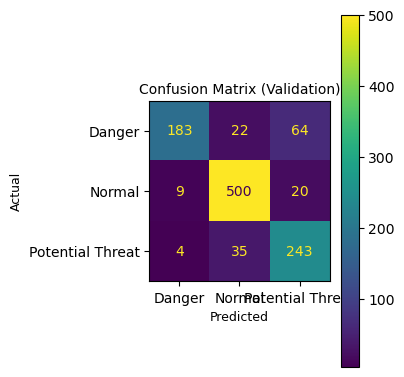


 CLASSIFICATION REPORT:

                  precision    recall  f1-score   support

          Danger       0.93      0.68      0.79       269
          Normal       0.90      0.95      0.92       529
Potential Threat       0.74      0.86      0.80       282

        accuracy                           0.86      1080
       macro avg       0.86      0.83      0.84      1080
    weighted avg       0.87      0.86      0.86      1080


 TRUE VS PREDICTED VALUES (all):

Index 0: True = Potential Threat, Predicted = Potential Threat
Index 1: True = Potential Threat, Predicted = Potential Threat
Index 2: True = Normal, Predicted = Normal
Index 3: True = Normal, Predicted = Normal
Index 4: True = Normal, Predicted = Normal
Index 5: True = Potential Threat, Predicted = Potential Threat
Index 6: True = Normal, Predicted = Normal
Index 7: True = Danger, Predicted = Danger
Index 8: True = Normal, Predicted = Normal
Index 9: True = Potential Threat, Predicted = Potential Threat
Index 10: True = Nor

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Device setup (same as before)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Model
hidden_dimension = 256
n_locations = len(location_encoder.classes_)

best_model = RiskLevelClassifier(hidden_dim=hidden_dimension, n_locations=n_locations).to(device)
best_model.load_state_dict(torch.load("best_multimodal_classifier.pth", map_location=device))
best_model.eval()

# DataLoader
batch_size = 32
test_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# For collecting predictions & labels
all_preds = []
all_labels = []

# Disable gradient computation
with torch.no_grad():
    for spectrograms, labels, locations in test_loader:
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)
        locations = locations.to(device)

        outputs = best_model(spectrograms, locations)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# -----------------------------

# -----------------------------
cm = confusion_matrix(all_labels, all_preds)
print("\n CONFUSION MATRIX:\n", cm)
plt.figure(figsize=(4, 4))   # Smaller size for screenshot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=risk_encoder.classes_)
disp.plot(cmap="viridis", values_format='d', ax=plt.gca())

plt.title("Confusion Matrix (Validation)", fontsize=10)
plt.xlabel("Predicted", fontsize=9)
plt.ylabel("Actual", fontsize=9)

plt.tight_layout()  # Removes extra white space
plt.show()

# Pretty version
print("\n CLASSIFICATION REPORT:\n")
print(classification_report(all_labels, all_preds, target_names=risk_encoder.classes_))


# -----------------------------

# -----------------------------
print("\n TRUE VS PREDICTED VALUES (all):\n")
for i in range(len(all_labels)):
    print(f"Index {i}: True = {risk_encoder.classes_[all_labels[i]]}, Predicted = {risk_encoder.classes_[all_preds[i]]}")


# -----------------------------

# -----------------------------
print("\n MISCLASSIFIED SAMPLES (Failing Cases):\n")

for i in range(len(all_labels)):
    if all_labels[i] != all_preds[i]:
        print(f" Index {i}: True = {risk_encoder.classes_[all_labels[i]]}, Predicted = {risk_encoder.classes_[all_preds[i]]}")


In [16]:
import torch
import librosa
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_dimension = 256          # same as you used during training
n_locations = len(location_encoder.classes_)   # encoder already fitted on training data

best_model = RiskLevelClassifier(hidden_dim=hidden_dimension,
                                 n_locations=n_locations).to(device)

best_model.load_state_dict(torch.load("best_multimodal_classifier.pth",
                                      map_location=device))
best_model.eval()


SAMPLE_RATE = 22050
N_MELS = 128
duration = 5   # seconds

def preprocess_audio(file_path):
    
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=duration)

   
    if len(audio) < sr * duration:
        audio = np.pad(audio, (0, sr*duration - len(audio)))

   
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MELS)
    mel_db = librosa.power_to_db(mel, ref=np.max)

  
    mel_db = librosa.util.fix_length(mel_db, size=216, axis=1)

   
    mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-9)

   
    mel_tensor = torch.tensor(mel_db).unsqueeze(0).unsqueeze(0).float().to(device)
    return mel_tensor


def predict_risk(audio_path, location_name):
    # Preprocess audio
    x = preprocess_audio(audio_path)

   
    loc_encoded = location_encoder.transform([location_name])[0]
    loc_tensor = torch.tensor([loc_encoded]).long().to(device)

   
    with torch.no_grad():
        output = best_model(x, loc_tensor)       # shape: [1, 3]
        pred_class = torch.argmax(output, dim=1).item()

    
   
    risk_label = risk_encoder.classes_[pred_class]
    return risk_label


audio_path = "/Users/jeevansai/Desktop/PYTHON FOR DATA SCIENCE/AIML Vth semester/project on neural networks/explosion.mp3"



location_name = "Home"   

predicted_label = predict_risk(audio_path, location_name)
print(f"Predicted Risk Level for '{audio_path}' at '{location_name}': {predicted_label}")


Predicted Risk Level for '/Users/jeevansai/Desktop/PYTHON FOR DATA SCIENCE/AIML Vth semester/project on neural networks/explosion.mp3' at 'Home': Normal


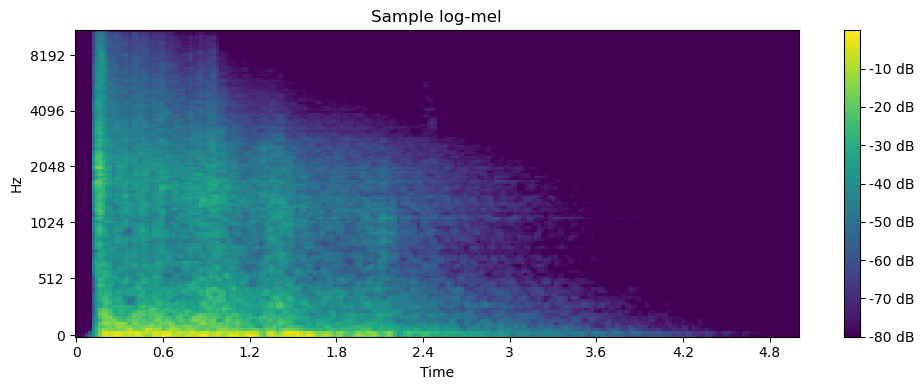

In [32]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Path to any ONE audio sample from your dataset
sample_audio_path = "/Users/jeevansai/Desktop/PYTHON FOR DATA SCIENCE/AIML Vth semester/project on neural networks/explosion.mp3"

# Load audio
audio, sr = librosa.load(sample_audio_path, sr=22050, duration=5)

# Pad/Trim
if len(audio) < sr * 5:
    audio = np.pad(audio, (0, sr*5 - len(audio)))

# Generate Mel Spectrogram
mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)

# ----------- PLOT (same style as your screenshot) ----------
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, sr=sr, x_axis="time", y_axis="mel", cmap='viridis')
plt.title("Sample log-mel")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()